In [1]:
import pandas as pd
import numpy as np

from dataprep.clean import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from optuna import create_study, visualization
from optuna.pruners import SuccessiveHalvingPruner
from optuna.samplers import RandomSampler
import shap
import kaleido
# import plotly.io as pio
# pio.kaleido.scope.default_format = "svg"
import matplotlib.pyplot as plt

import machine_learning_pipeline as mlp
%load_ext autoreload
%autoreload 2

c:\Users\Dell\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\Dell\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
C:\Users\Dell\AppData\Local\Temp/ipykernel_29672/194931785.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was too old on your system - pyarrow 10.0.1 is the current minimum supported version as of this release.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
 

### Data Wrangling

#### Loading train and test dfs

In [2]:
dataset_folder = 'S3 E24 Binary Prediction of Smoker Status using Bio Signals'

train_df = pd.read_csv(f'{dataset_folder}/train.csv')
test_df = pd.read_csv(f'{dataset_folder}/test.csv')

# cleaning the headers
train_df = clean_headers(train_df)
# confirming the id is unique for each row and setting it 
# as the index
assert train_df.id.nunique() == len(train_df)
train_df = train_df.set_index('id')

test_df = clean_headers(test_df)
assert test_df.id.nunique() == len(test_df)
test_df = test_df.set_index('id')

train_df

Column Headers Cleaning Report:
	17 values cleaned (70.83%)
Column Headers Cleaning Report:
	17 values cleaned (73.91%)


age  height_cm  weight_kg  waist_cm  eyesight_left  eyesight_right  \
id                                                                           
0        55        165         60      81.0            0.5             0.6   
1        70        165         65      89.0            0.6             0.7   
2        20        170         75      81.0            0.4             0.5   
3        35        180         95     105.0            1.5             1.2   
4        30        165         60      80.5            1.5             1.0   
...     ...        ...        ...       ...            ...             ...   
159251   40        155         45      69.0            1.5             2.0   
159252   50        155         75      82.0            1.0             1.0   
159253   40        160         50      66.0            1.5             1.0   
159254   50        165         75      92.0            1.2             1.0   
159255   40        145         45      76.4            1.0             1.2   

        hearing_left  hearing_right  systolic  relaxation  ...  hdl  ldl  \
id                                                         ...             
0                  1              1       135          87  ...   40   75   
1                  2              2       146          83  ...   57  126   
2                  1              1       118          75  ...   45   93   
3                  1              1       131          88  ...   38  102   
4                  1              1       121          76  ...   44   93   
...              ...            ...       ...         ...  ...  ...  ...   
159251             1              1       127          80  ...   72  159   
159252             1              1       120          80  ...   64  108   
159253             1              1       114          70  ...   87   93   
159254             1              1       121          90  ...   55   80   
159255             1              1       125          87  ...   87   81   

        hemoglobin  urine_protein  serum_creatinine  ast  alt  gtp  \
id                                                                   
0             16.5              1               1.0   22   25   27   
1             16.2              1               1.1   27   23   37   
2             17.4              1               0.8   27   31   53   
3             15.9              1               1.0   20   27   30   
4             15.4              1               0.8   19   13   17   
...            ...            ...               ...  ...  ...  ...   
159251        14.5              1               0.8   25   26   13   
159252        14.5              1               0.6   21   20   18   
159253        10.9              1               0.6   15    9   12   
159254        14.4              1               1.1   22   17   37   
159255        14.0              1               0.8   21   16   17   

        dental_caries  smoking  
id                              
0                   0        1  
1                   1        0  
2                   0        1  
3                   1        0  
4                   0        1  
...               ...      ...  
159251              0        0  
159252              0        0  
159253              0        0  
159254              0        1  
159255              0        0  

[159256 rows x 23 columns]

#### Handling the Target/Dependent Variable

In [3]:
target = 'smoking'
# defining the type of our target: 'continuous', 'binary' or 'multiclass'
target_type = 'binary'

# checking that the target_type is a valid one
assert target_type in ['continuous', 'binary', 'multiclass']

# encoding the target for categorical string target columns
if target_type != 'continuous':
    le = LabelEncoder()
    train_df[target] = le.fit_transform(train_df[target].tolist())
    target_classes = list(le.classes_)
    print('Target Encoding:')
    for i, clss in enumerate(target_classes): print(target + ' ' + str(clss) + ' -> ' + target + ' ' + str(i)) 

Target Encoding:
smoking 0 -> smoking 0
smoking 1 -> smoking 1


#### Splitting features into numerical and categorical types

In [4]:
# creating a dataframe that lets us know the data types of each one of our 
# features
data_types = pd.DataFrame(train_df.dtypes, columns=['feature_type'])
data_types['unique_values'] = train_df.nunique()
data_types

feature_type  unique_values
age                        int64             18
height_cm                  int64             14
weight_kg                  int64             28
waist_cm                 float64            531
eyesight_left            float64             20
eyesight_right           float64             17
hearing_left               int64              2
hearing_right              int64              2
systolic                   int64            112
relaxation                 int64             75
fasting_blood_sugar        int64            229
cholesterol                int64            227
triglyceride               int64            392
hdl                        int64            108
ldl                        int64            222
hemoglobin               float64            134
urine_protein              int64              6
serum_creatinine         float64             28
ast                        int64            140
alt                        int64            188
gtp                        int64            362
dental_caries              int64              2
smoking                    int64              2

Although all the columns are numeric, the small number of diffetent values for some columns suggests that the they could be interpreted as categorical

In [5]:
# setting a threshold to determine categorical columns versus numerical
cat_threshold = 10
numerical_features, categorical_features = mlp.split_features(df=train_df, target_col=target, categorical_threshold=cat_threshold)

The numerical features are: ['waist_cm', 'eyesight_left', 'eyesight_right', 'hemoglobin', 'serum_creatinine', 'age', 'height_cm', 'weight_kg', 'systolic', 'relaxation', 'fasting_blood_sugar', 'cholesterol', 'triglyceride', 'hdl', 'ldl', 'ast', 'alt', 'gtp']
The categorical features are: ['hearing_left', 'hearing_right', 'urine_protein', 'dental_caries']


### EDA

#### Pairplot
These graphs help us visualize the relationships between our numerical features and the target. For numerical targets the last row of the pairplot corresponds to the target; for categorical targets, the target can be seen as the marker color in each graph.

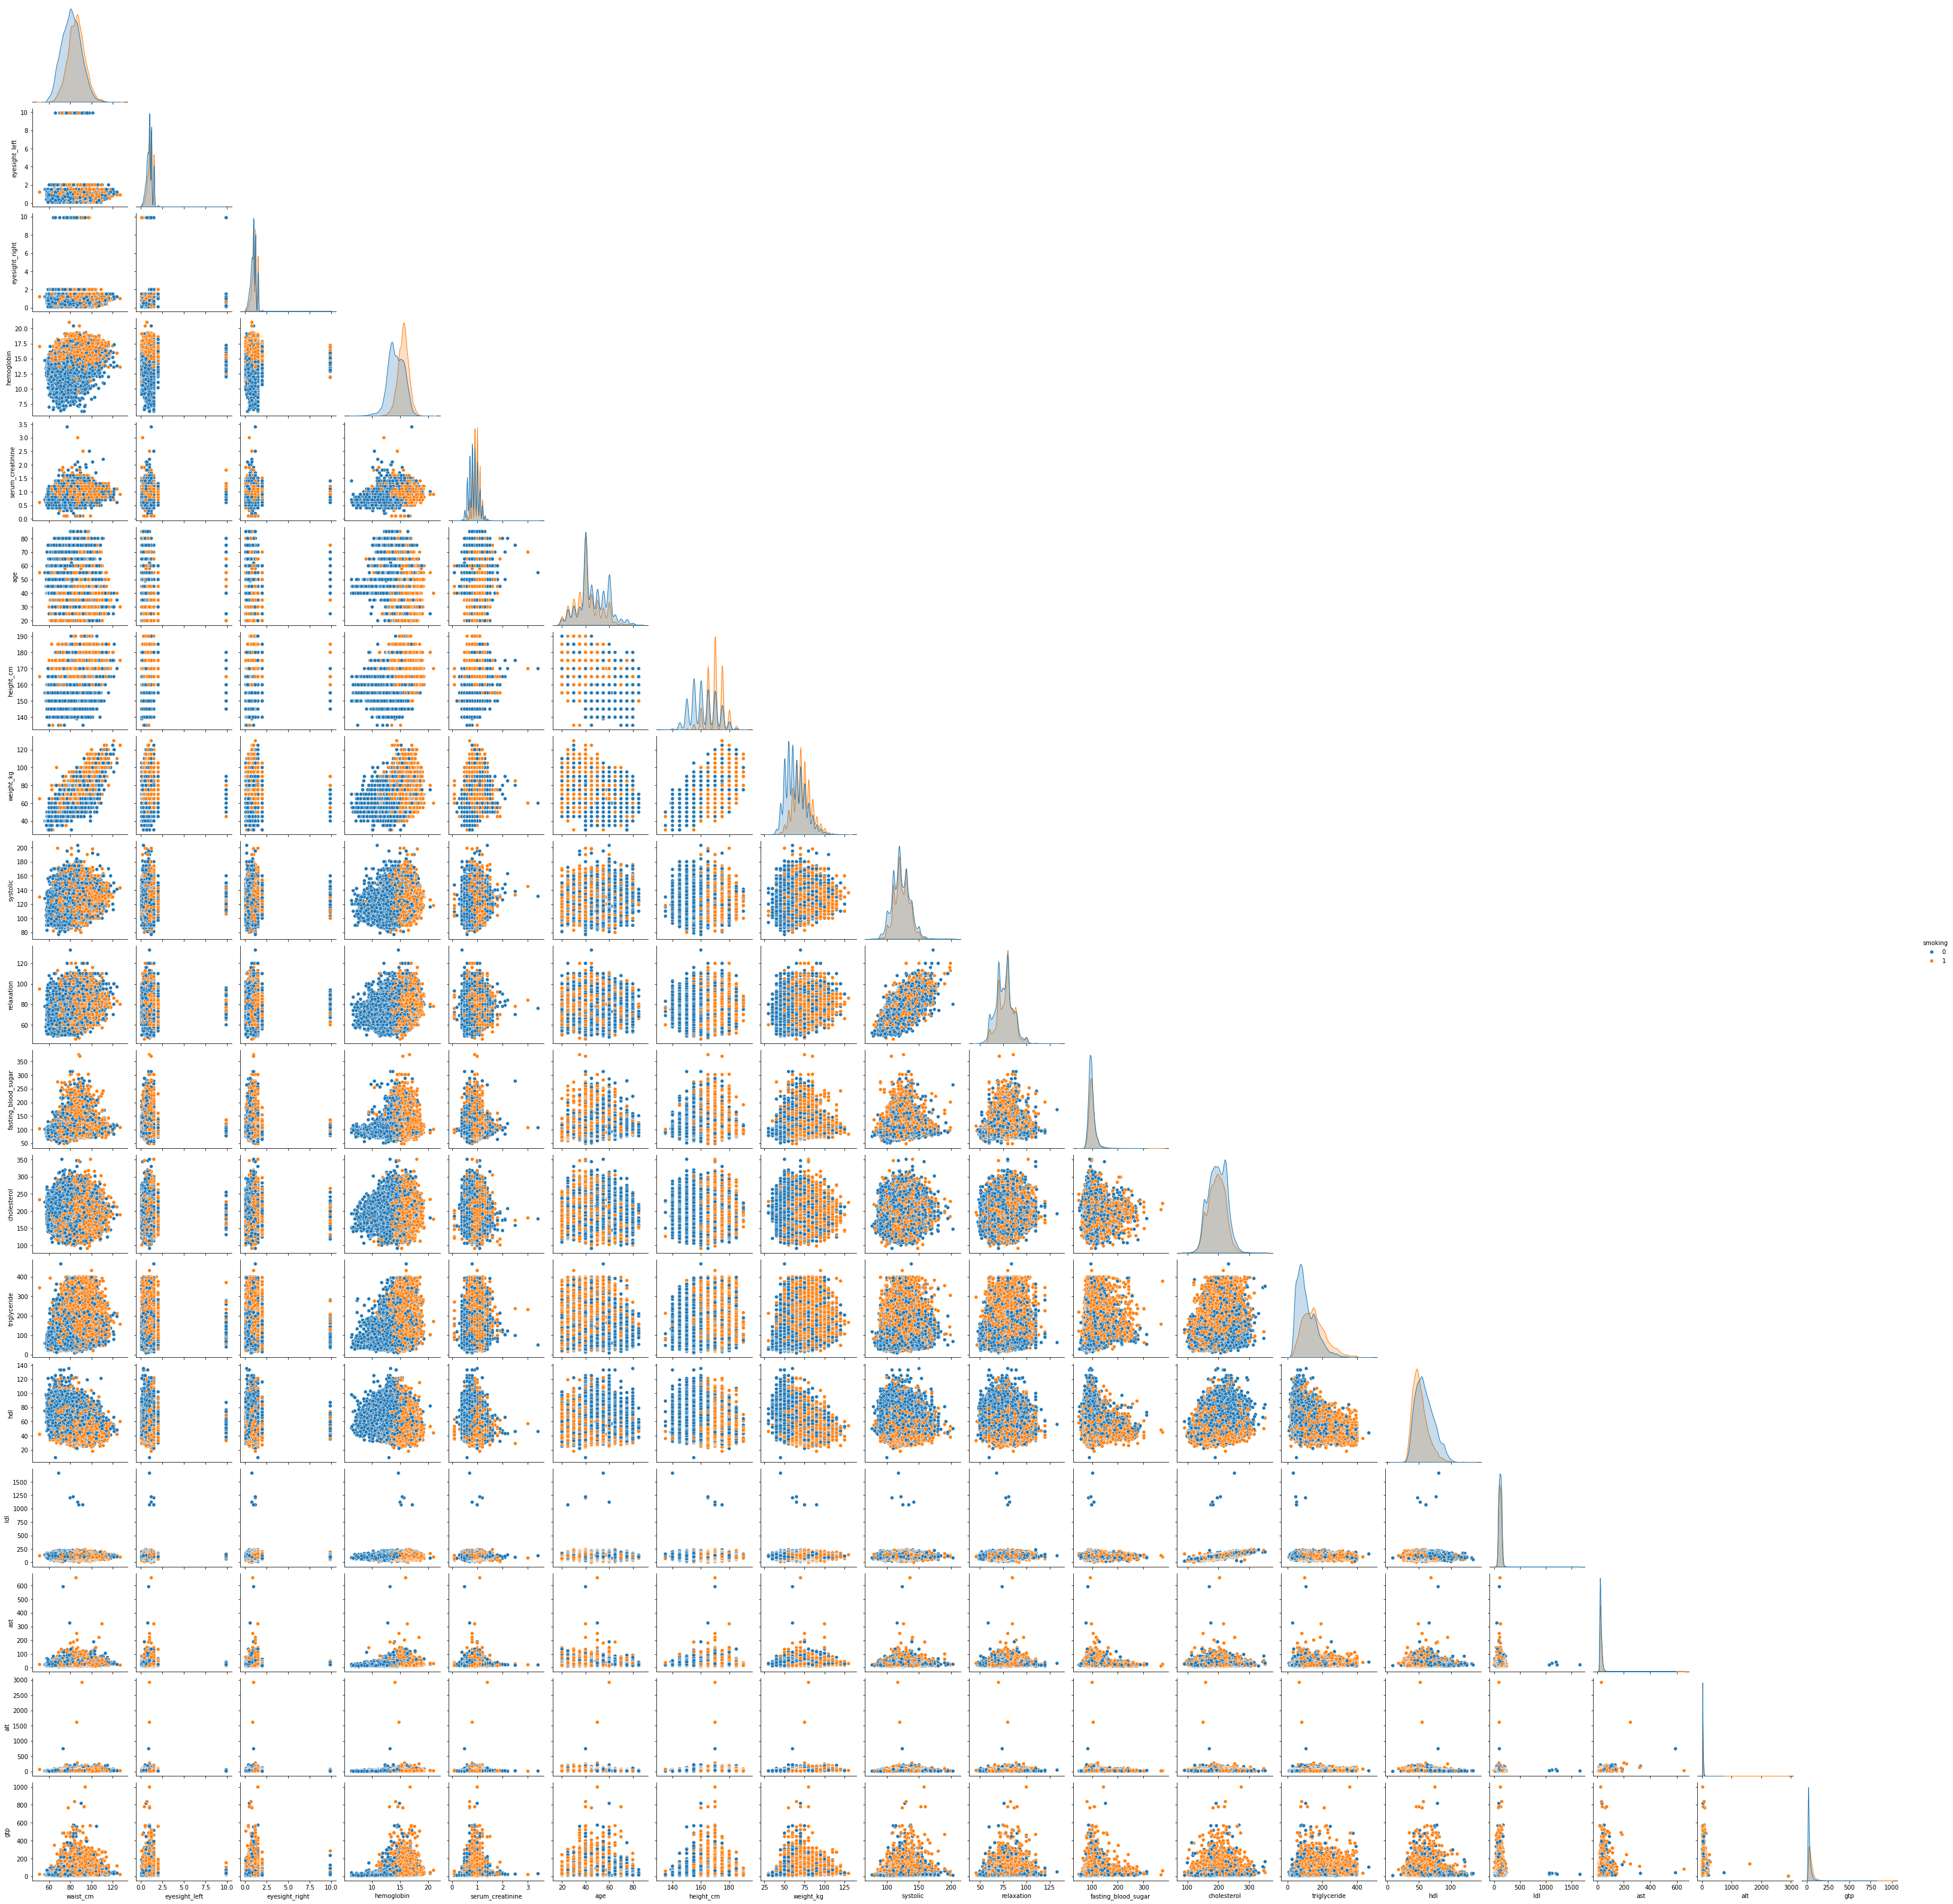

In [6]:
mlp.pairplot(df=train_df.reset_index(),
             numerical_features=numerical_features,
             target_type=target_type,
             target_col=target,
             sample=0.5)

#### Numerical Features Distribution Comparison
The graphs below are useful to identify any major differences between our train and test sets that can impact our models. It also shows the general distribution of each of the numerical features

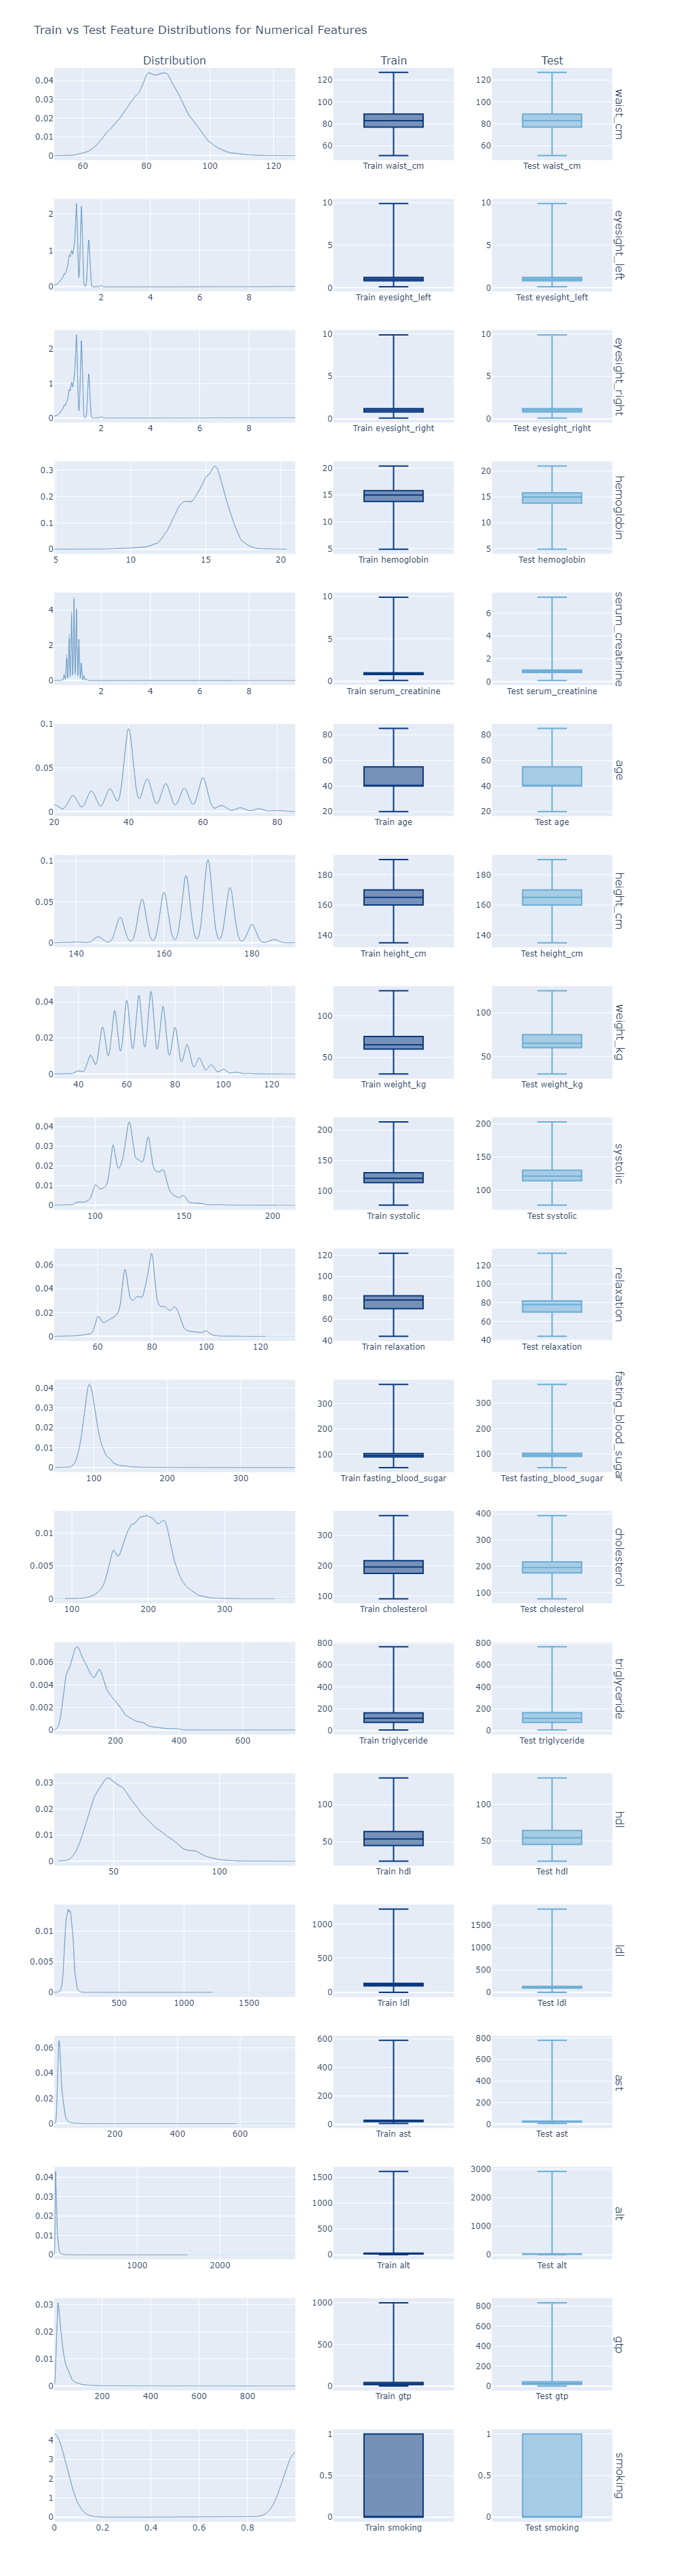

In [6]:
mlp.train_test_distribution_plots(train_df,
                                  train_df,
                                  numerical_features + [target],
                                  sample=0.5,
                                  renderer='png'
                                  ) 

#### Categorical Features Distribution Comparison
The graphs below are useful to identify any major differences between our train and test sets that can impact our models. It also shows the general distribution of each of the cateorical features

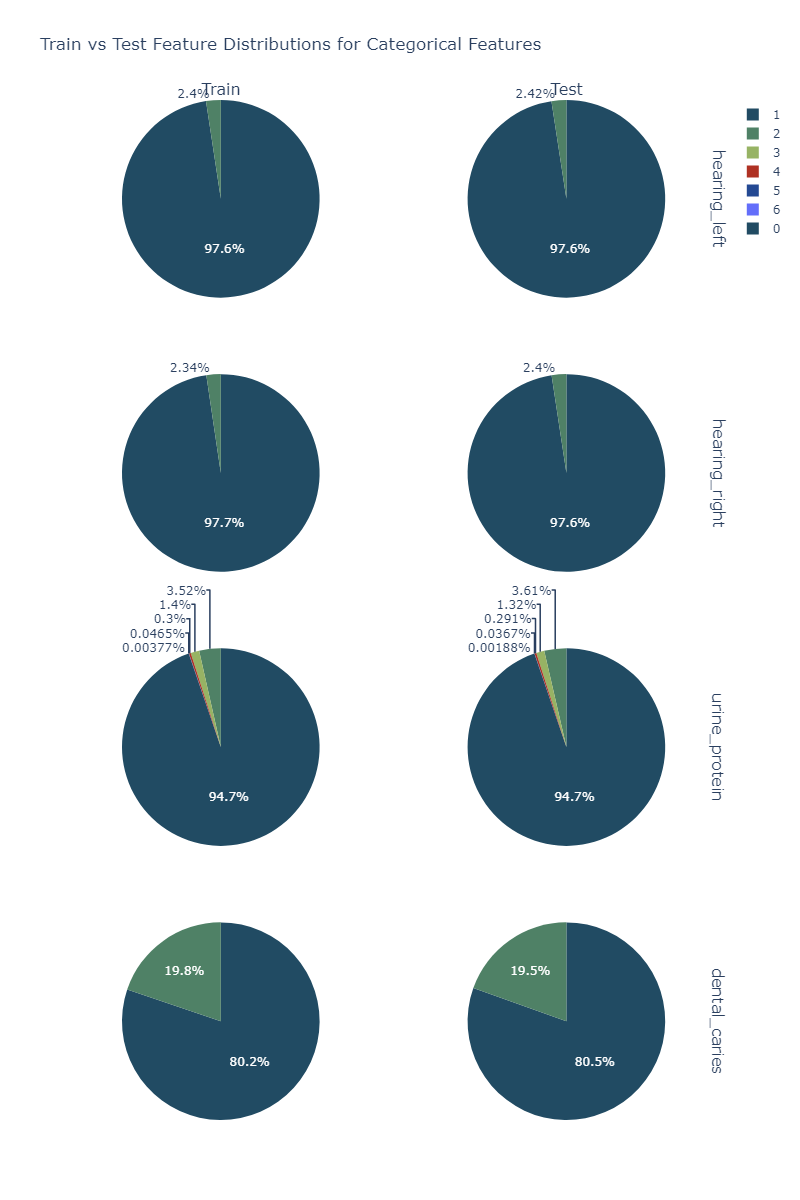

In [6]:
mlp.train_test_categorical_piecharts(train_df,
                                     test_df,
                                     categorical_features,
                                     renderer='png'
                                     )

#### Correlation Matrix

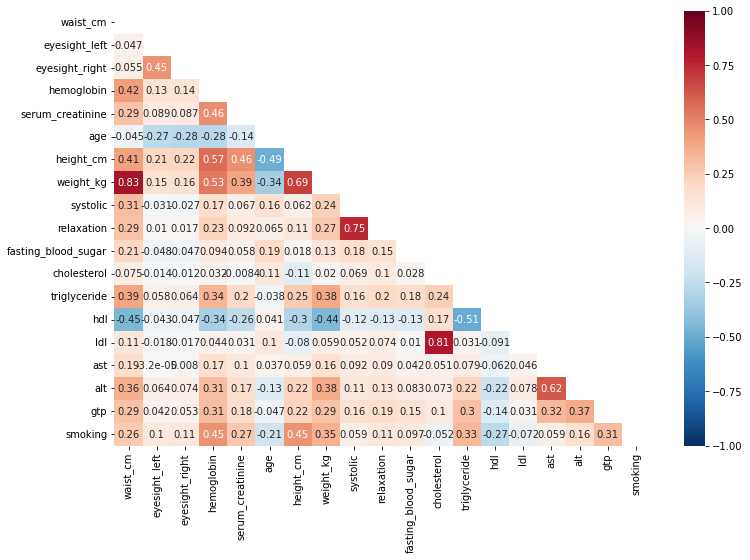

In [7]:
mlp.correlation_plot(train_df[numerical_features + [target]])

### Model Training with Optuna

#### Declaring variables needed for optimization step

In [6]:
# During the model fitting step, the optuna optimizer will include the algorithm 
# as one of the  hyperparameters of the model. It will try to find the one that 
# performs the best for our problem.

if target_type == 'continuous':    
    optimization_objective = 'regression'
    # available algorithms for regression tasks. 
    algorithms = [
                    # 'linear',
                    # 'ridge',
                    # 'histgb',                     
                    # 'extratrees', 
                    'lgb',
                    # 'xgb', 
                    # 'catboost'
                ] 
    
    # scoring for cross-validation
    optimization_scoring = 'neg_mean_squared_log_error'

elif target_type == 'binary':
    optimization_objective = 'classification'
    # available algorithms for binary classification tasks
    algorithms = [
                    # 'histgb',                     
                    # 'extratrees', 
                    'lgb',
                    # 'xgb', 
                    # 'catboost'
                ]
    # scoring for cross-validation
    optimization_scoring = 'roc_auc'

elif target_type == 'multiclass':
    optimization_objective = 'multiclass'
    # available algorithms for multiclass classification tasks
    algorithms = [
                    'histgb',                     
                    'lgb',
                ]
    # scoring for cross-validation
    optimization_scoring = 'neg_log_loss'

#### Model Optimization

In [8]:
pd.set_option('future.no_silent_downcasting', True)
with_imputation = False
with_interactions = False
with_feature_selection = False

train_df = train_df.dropna(subset=target)

if with_imputation:
    X_train, X_test, y_train, y_test = train_test_split(train_df.drop(target, axis=1), 
                                                        train_df[target], 
                                                        test_size=0.2,
                                                        random_state=0)   
else:
    train_df_no_missing_vals = train_df.dropna().copy()
    X_train, X_test, y_train, y_test = train_test_split(train_df_no_missing_vals.drop(target, axis=1), 
                                                        train_df_no_missing_vals[target], 
                                                        test_size=0.2,
                                                        random_state=0)

# declaring our optuna study
factor = 2
# the pruner parameter helps make the optimization much faster as it will prune
# any iterations that don't look promising right from the start
study = create_study(study_name='optimization', 
                     direction='maximize',
                     pruner=SuccessiveHalvingPruner(reduction_factor=factor),
                     sampler=RandomSampler(seed=0))


# custom function to fit the model using smart hyperparameter search with optuna. This 
# parameter search is not restricted to the algorithm's hyperparameters. The algorithm
# itself is part of the parameters to be optimized. Data preprocessing decisions are 
# also included here, such as the scaling approach for numerical features, the encoding 
# technique for categorical variables, as well as feature selection.
study.optimize(lambda trial: mlp.objective(trial, 
                                           X_train, 
                                           y_train, 
                                           objective=optimization_objective,
                                           algorithms=algorithms,
                                           cv_scoring=optimization_scoring,
                                           numerical_columns=numerical_features, 
                                           categorical_columns=categorical_features,
                                           with_feature_selection=with_feature_selection,
                                           with_imputation=with_imputation, 
                                           with_interactions=with_interactions,
                                           base=factor, 
                                           n_rungs=4), 
               n_trials=10)

[I 2024-05-02 18:28:09,447] A new study created in memory with name: optimization
[I 2024-05-02 18:28:22,638] Trial 0 finished with value: 0.8653661651745136 and parameters: {'with_centering': False, 'with_scaling': True, 'categorical_encoder': 'onehot', 'algorithm': 'lgb', 'lambda_l1': 0.00017240426024865184, 'lambda_l2': 0.028770084050677908, 'num_leaves': 113, 'feature_fraction': 0.9025957007038717, 'bagging_fraction': 0.9672964844509263, 'bagging_freq': 4, 'min_child_samples': 81}. Best is trial 0 with value: 0.8653661651745136.
[I 2024-05-02 18:28:38,740] Trial 1 finished with value: 0.8650392040913969 and parameters: {'with_centering': False, 'with_scaling': True, 'categorical_encoder': 'onehot', 'algorithm': 'lgb', 'lambda_l1': 7.435205853060173e-08, 'lambda_l2': 1.5928833561691773e-08, 'num_leaves': 214, 'feature_fraction': 0.8003410758548655, 'bagging_fraction': 0.8830109334221372, 'bagging_freq': 10, 'min_child_samples': 81}. Best is trial 0 with value: 0.8653661651745136.
[I

In [ ]:
import joblib
joblib.dump(study, "ghg_scope1_lgb_100000.pkl")

In [9]:
# saving the models best parameters and trial and printing its best score
best_model_params = study.best_params
best_trial = study.best_trial
# printing the score of the best model
print(study.best_value)

0.8653661651745136


#### Optuna trials visualizations

In [10]:
visualization.plot_optimization_history(study)

In [ ]:
visualization.plot_param_importances(study, target_name="ms")

#### Instantiating the model

In [11]:
# calling the best trial and instantiating the model
model = mlp.instantiate_model(best_trial, 
                              numerical_features, 
                              categorical_features, 
                              optimization_objective, 
                              algorithms,
                              with_feature_selection=with_feature_selection,
                              with_imputation=with_imputation,
                              with_interactions=with_interactions)
model.fit(X_train, y_train)

Pipeline(steps=[('processor',
                 ColumnTransformer(transformers=[('numerical_pipeline',
                                                  Pipeline(steps=[('imputer',
                                                                   PassthroughTransformer()),
                                                                  ('pandarizer',
                                                                   PassthroughTransformer()),
                                                                  ('interactions',
                                                                   PassthroughTransformer()),
                                                                  ('scaler',
                                                                   RobustScaler(with_centering=False))]),
                                                  ['waist_cm', 'eyesight_left',
                                                   'eyesight_right',
                                                   'hemoglobin',
                                                   'serum_creatinine', 'age',
                                                   '...
                                                                  ('encoder',
                                                                   OneHotEncoder())]),
                                                  ['hearing_left',
                                                   'hearing_right',
                                                   'urine_protein',
                                                   'dental_caries'])])),
                ('model',
                 LGBMClassifier(bagging_fraction=0.9672964844509263,
                                bagging_freq=4,
                                feature_fraction=0.9025957007038717,
                                lambda_l1=0.00017240426024865184,
                                lambda_l2=0.028770084050677908,
                                min_child_samples=81, num_leaves=113,
                                objective='binary', random_state=0,
                                verbosity=-1))])

In [12]:
# printing score on the test set
print(model.score(X_test,y_test))

0.7845975134999372


### Model Explainability with SHAP

#### Fitting the model on preprocessed data

In [13]:
best_model_params

{'with_centering': False,
 'with_scaling': True,
 'categorical_encoder': 'onehot',
 'algorithm': 'lgb',
 'lambda_l1': 0.00017240426024865184,
 'lambda_l2': 0.028770084050677908,
 'num_leaves': 113,
 'feature_fraction': 0.9025957007038717,
 'bagging_fraction': 0.9672964844509263,
 'bagging_freq': 4,
 'min_child_samples': 81}

#### Applying preprocessing steps to our dataset and Fitting the model
To be able to compute the shap values we need the preprocessed dataset and the chosen model. We'll use the best_model_params dictionary to retrieve them

In [14]:
final_processor = model.named_steps['processor']
final_learner = model.named_steps['model']

X_train_preprocessed = final_processor.transform(X_train)
X_test_preprocessed = final_processor.transform(X_test)

if with_imputation:
    train_df_preprocessed = final_processor.transform(train_df)
else:
    train_df_preprocessed = final_processor.transform(train_df_no_missing_vals)

if with_interactions:
    processed_numerical_features = final_processor.named_transformers_['numerical_pipeline']['interactions'].get_feature_names_out()
else:
    processed_numerical_features = numerical_features

if with_imputation:
    get_features_step = 'imputer'
else:
    get_features_step = 'encoder'
processed_categorical_features = final_processor.named_transformers_['categorical_pipeline'][get_features_step].get_feature_names_out().tolist()

X_train_preprocessed = pd.DataFrame(X_train_preprocessed, 
                                    columns=processed_numerical_features + processed_categorical_features, 
                                    index=X_train.index)
X_test_preprocessed = pd.DataFrame(X_test_preprocessed, 
                                   columns=processed_numerical_features + processed_categorical_features, 
                                   index=X_test.index)
train_df_preprocessed = pd.DataFrame(train_df_preprocessed, 
                                     columns=processed_numerical_features + processed_categorical_features, 
                                     index=train_df.index)

X_train_preprocessed

waist_cm  eyesight_left  eyesight_right  hemoglobin  serum_creatinine  \
id                                                                              
1485    5.750000           2.50            2.25        7.20               2.5   
75550   6.833333           1.75            1.25        7.65               5.0   
26543   7.416667           3.00            3.75        7.90               3.5   
36090   7.333333           2.25            2.50        7.95               5.0   
130765  7.666667           2.50            2.50        7.30               4.5   
...          ...            ...             ...         ...               ...   
97639   7.083333           1.50            2.25        6.00               5.0   
95939   5.841667           3.75            3.00        6.50               4.5   
152315  5.666667           2.00            1.75        5.85               4.5   
117952  7.000000           1.50            1.00        6.70               3.5   
43567   7.250000           3.00            3.00        8.00               4.5   

             age  height_cm  weight_kg  systolic  relaxation  ...  \
id                                                            ...   
1485    2.666667       15.5   3.000000    6.7500    6.583333  ...   
75550   2.666667       17.5   5.333333    9.3750    8.333333  ...   
26543   2.000000       18.5   6.333333    7.5000    6.666667  ...   
36090   3.000000       16.5   4.333333    7.0625    5.833333  ...   
130765  2.333333       18.0   5.666667    8.0000    6.833333  ...   
...          ...        ...        ...       ...         ...  ...   
97639   3.000000       15.0   3.666667    6.3750    5.666667  ...   
95939   2.666667       16.0   4.000000    6.8125    6.000000  ...   
152315  2.666667       15.5   3.333333    5.8750    5.666667  ...   
117952  2.666667       15.5   4.666667    6.8750    5.000000  ...   
43567   2.666667       17.0   5.000000    7.7500    7.416667  ...   

        hearing_right_1  hearing_right_2  urine_protein_1  urine_protein_2  \
id                                                                           
1485                1.0              0.0              1.0              0.0   
75550               1.0              0.0              1.0              0.0   
26543               1.0              0.0              1.0              0.0   
36090               1.0              0.0              1.0              0.0   
130765              1.0              0.0              1.0              0.0   
...                 ...              ...              ...              ...   
97639               1.0              0.0              1.0              0.0   
95939               1.0              0.0              1.0              0.0   
152315              1.0              0.0              1.0              0.0   
117952              1.0              0.0              1.0              0.0   
43567               1.0              0.0              1.0              0.0   

        urine_protein_3  urine_protein_4  urine_protein_5  urine_protein_6  \
id                                                                           
1485                0.0              0.0              0.0              0.0   
75550               0.0              0.0              0.0              0.0   
26543               0.0              0.0              0.0              0.0   
36090               0.0              0.0              0.0              0.0   
130765              0.0              0.0              0.0              0.0   
...                 ...              ...              ...              ...   
97639               0.0              0.0              0.0              0.0   
95939               0.0              0.0              0.0              0.0   
152315              0.0              0.0              0.0              0.0   
117952              0.0              0.0              0.0              0.0   
43567               0.0              0.0              0.0              0.0   

        dental_caries_1  d

#### Calculating Shap Values

In [15]:
explainer = shap.TreeExplainer(final_learner)
# explainer = shap.Explainer(final_learner)
shap_values = explainer.shap_values(X_train_preprocessed, y_train)

# explainer = shap.KernelExplainer(final_learner.predict, X_train_preprocessed)
# shap_values = explainer.shap_values(X_train_preprocessed)

c:\Users\Dell\anaconda3\lib\site-packages\shap\explainers\_tree.py:386: UserWarning:

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



#### Shap summary plot

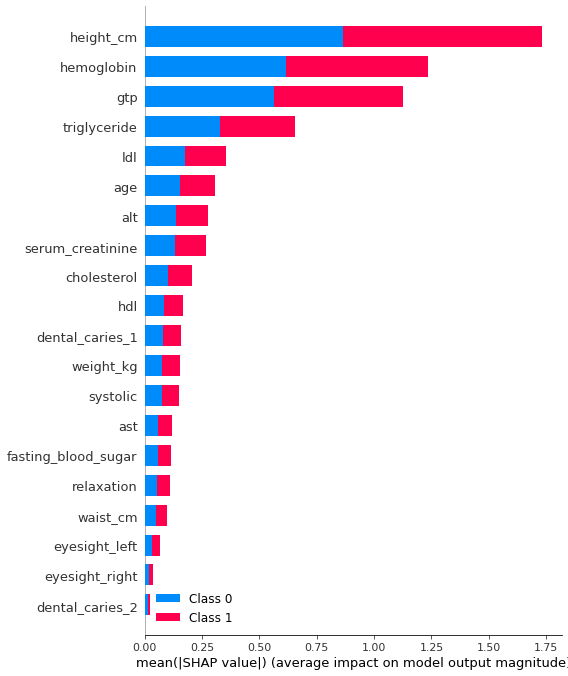

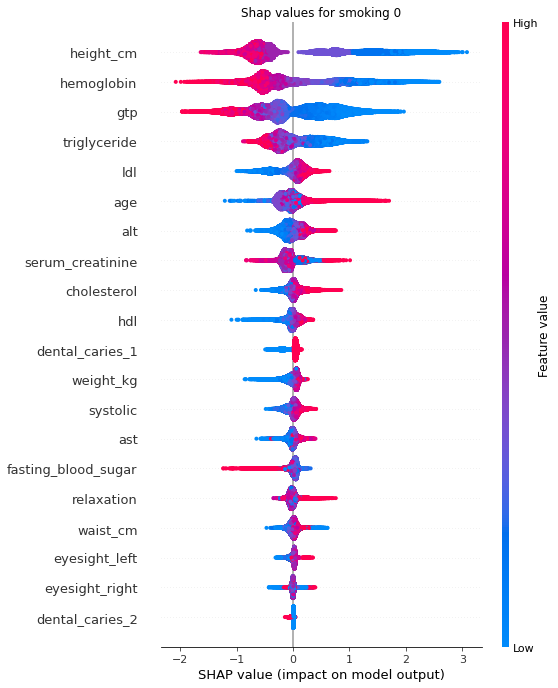

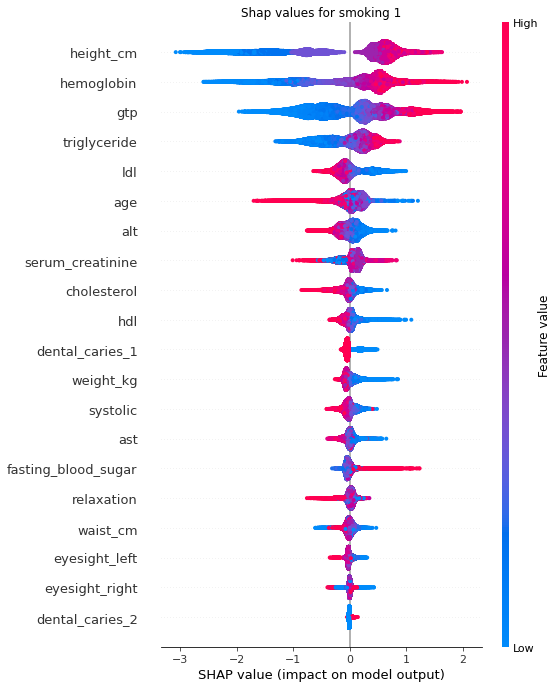

In [16]:
if target_type == 'continuous':     # graph not supported for multiclass
    shap.summary_plot(shap_values, 
                      X_train_preprocessed, 
                      feature_names=X_train_preprocessed.columns, 
                      plot_type='dot')
else:
    shap.summary_plot(shap_values, 
                      X_train_preprocessed, 
                      plot_type="bar", 
                      feature_names = X_train_preprocessed.columns)

    for i, tclass in enumerate(target_classes):
        shap.summary_plot(shap_values[i], 
                  X_train_preprocessed, 
                  plot_type="dot", 
                  feature_names = X_train_preprocessed.columns,
                  show=False) 
        plt.title(f'Shap values for {target} {tclass}')
        plt.show() 


#### Partial Dependence Plots

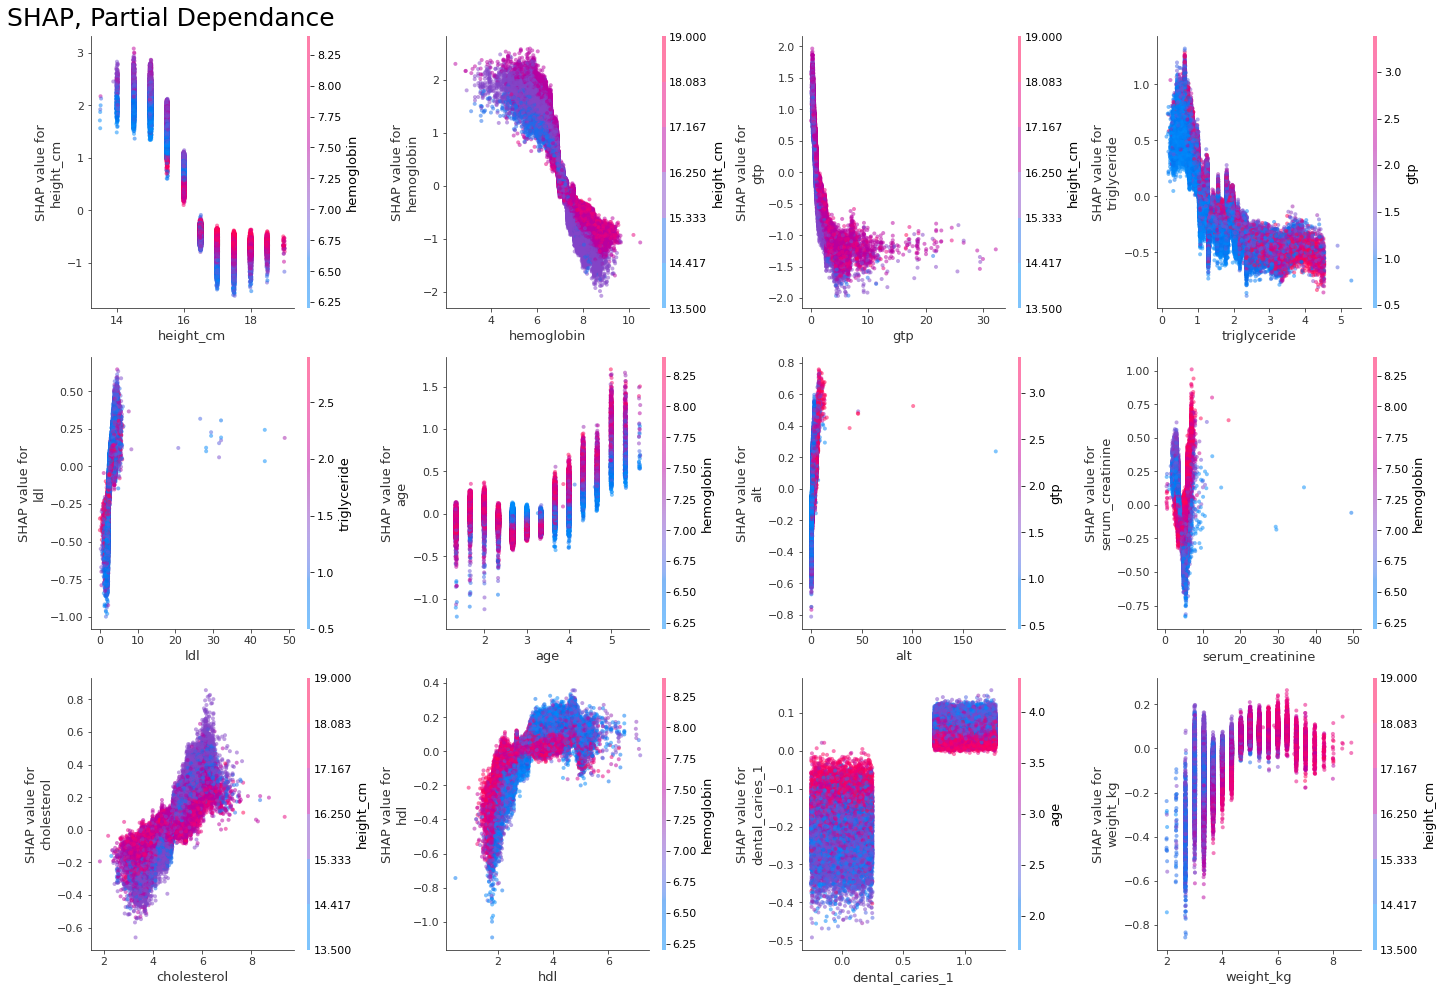

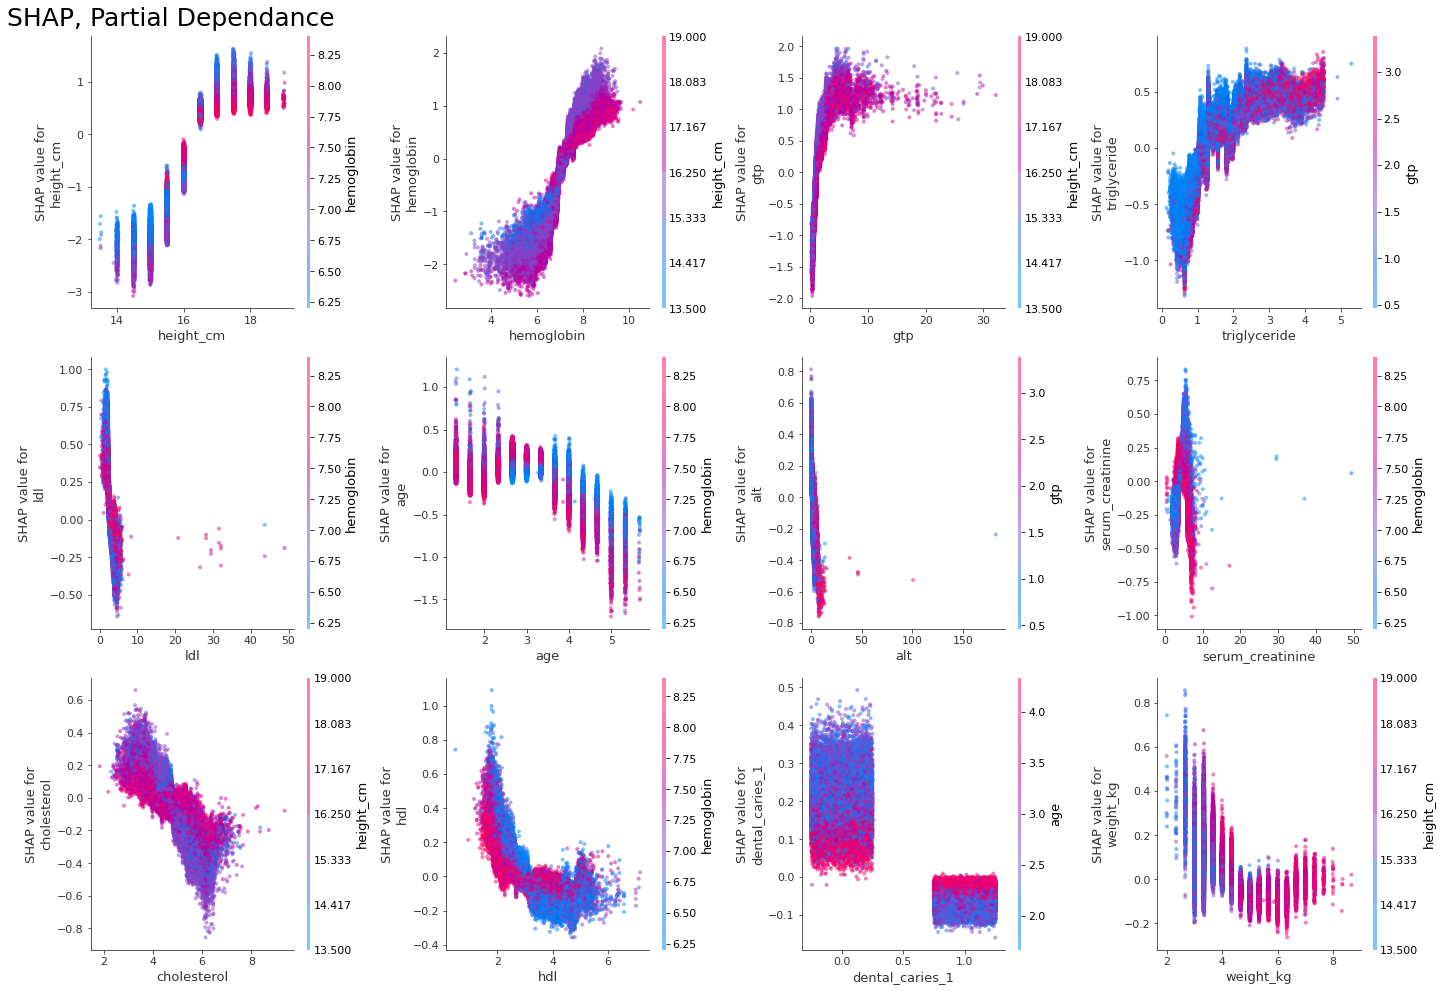

In [17]:
if target_type != 'continuous':
    # producing one graph for each class
    for i, tclass in enumerate(target_classes):
        mlp.shap_partial_dependence_plots(X_train_preprocessed, shap_values[i], n_charts=12) 
else:
    mlp.shap_partial_dependence_plots(X_train_preprocessed, shap_values, n_charts=12)

Takeaways from the previous graphs: 

### Model Predictions Analysis

#### Train Set

In [18]:
if target_type == 'continuous':
    train_results = mlp.append_predictions(model=model, 
                                           df=X_train, 
                                           target_values=y_train,
                                           target_name=target,
                                           target_type=target_type, 
                                           df_preprocessed=X_train_preprocessed
                                           )
else:
    train_results = mlp.append_predictions(model=model, 
                                           df=X_train, 
                                           target_values=y_train,
                                           target_name=target,
                                           target_type=target_type, 
                                           df_preprocessed=X_train_preprocessed, 
                                           label_encoder=le)

train_results

id  waist_cm  eyesight_left  eyesight_right  hemoglobin  \
0         1485  5.750000           2.50            2.25        7.20   
1        75550  6.833333           1.75            1.25        7.65   
2        26543  7.416667           3.00            3.75        7.90   
3        36090  7.333333           2.25            2.50        7.95   
4       130765  7.666667           2.50            2.50        7.30   
...        ...       ...            ...             ...         ...   
127399   97639  7.083333           1.50            2.25        6.00   
127400   95939  5.841667           3.75            3.00        6.50   
127401  152315  5.666667           2.00            1.75        5.85   
127402  117952  7.000000           1.50            1.00        6.70   
127403   43567  7.250000           3.00            3.00        8.00   

        serum_creatinine       age  height_cm  weight_kg  systolic  ...  \
0                    2.5  2.666667       15.5   3.000000    6.7500  ...   
1                    5.0  2.666667       17.5   5.333333    9.3750  ...   
2                    3.5  2.000000       18.5   6.333333    7.5000  ...   
3                    5.0  3.000000       16.5   4.333333    7.0625  ...   
4                    4.5  2.333333       18.0   5.666667    8.0000  ...   
...                  ...       ...        ...        ...       ...  ...   
127399               5.0  3.000000       15.0   3.666667    6.3750  ...   
127400               4.5  2.666667       16.0   4.000000    6.8125  ...   
127401               4.5  2.666667       15.5   3.333333    5.8750  ...   
127402               3.5  2.666667       15.5   4.666667    6.8750  ...   
127403               4.5  2.666667       17.0   5.000000    7.7500  ...   

        urine_protein_3  urine_protein_4  urine_protein_5  urine_protein_6  \
0                   0.0              0.0              0.0              0.0   
1                   0.0              0.0              0.0              0.0   
2                   0.0              0.0              0.0              0.0   
3                   0.0              0.0              0.0              0.0   
4                   0.0              0.0              0.0              0.0   
...                 ...              ...              ...              ...   
127399              0.0              0.0              0.0              0.0   
127400              0.0              0.0              0.0              0.0   
127401              0.0              0.0              0.0              0.0   
127402              0.0              0.0              0.0              0.0   
127403              0.0              0.0              0.0              0.0   

        dental_caries_1  dental_caries_2  pred_prob_0  pred_prob_1  \
0                   1.0              0.0     0.963989     0.036011   
1                   1.0              0.0     0.242500     0.757500   
2                   1.0              0.0     0.551264     0.448736   
3                   1.0              0.0     0.372566     0.627434   
4                   1.0              0.0     0.201168     0.798832   
...                 ...              ...          ...          ...   
127399              1.0              0.0     0.977809     0.022191   
127400              1.0              0.0     0.977634     0.022366   
127401              0.0              1.0     0.990124     0.009876   
127402              1.0              0.0     0.990973     0.009027   
127403              1.0              0.0     0.118998     0.881002   

        smoking_prediction  smoking  
0                        0        0  
1                        1        1  
2                        0        1  
3                        1        1  
4                        1        0  
...                    ...      ...  
127399                   0        0  
127400                   0        0  
127401                   0        0  
127402                   0        0  
127403                   1        1  

[127404 rows x 35 colum

##### Overall Observations vs. Predictions plot

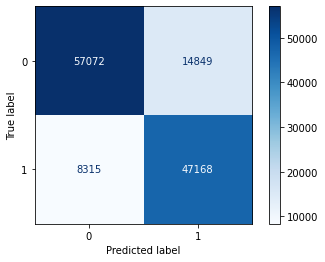

In [19]:
if target_type != 'continuous':
    target_classes = list(le.classes_)
    mlp.confusion_matrix_plot(y_true=train_results[target],
                              y_pred=train_results[target + '_prediction'],
                              labels=target_classes)

0.26042713785009663
0.08735372213118282


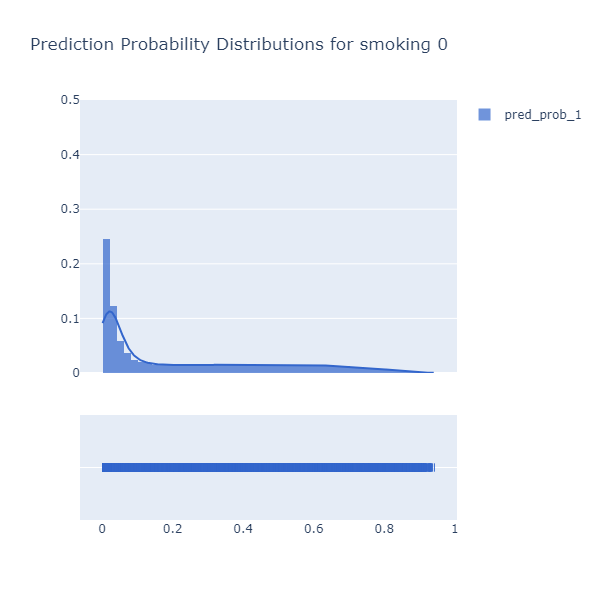

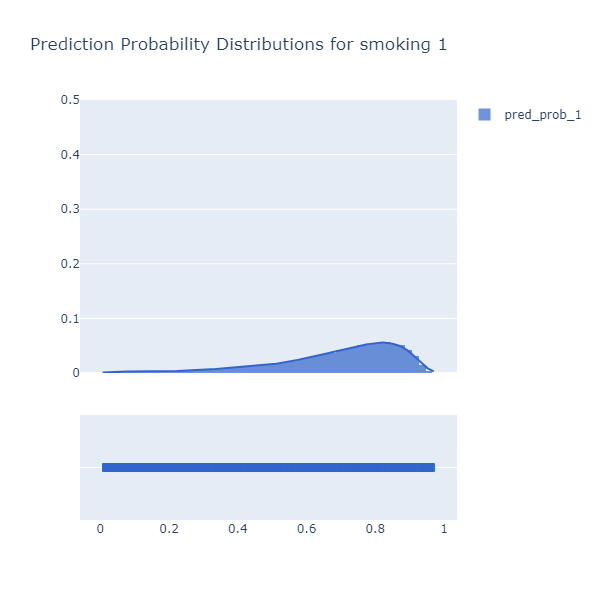

In [20]:
import plotly.express as px
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error

print(r2_score(train_results[target], train_results[f"{target}_prediction"]))
print(mean_squared_log_error(train_results[target], train_results[f"{target}_prediction"]))


if target_type == 'continuous':
    hover_col = 'id'
    fig = px.scatter(train_results, 
                     x=target, 
                     y=f"{target}_prediction", 
                     hover_data=[hover_col],
                     width=600,
                     height=600)
    fig.show()
else:
    mlp.prediction_probability_distribution_plot(preds_df=train_results, 
                                                 target_classes=target_classes, 
                                                 target_colname=target,
                                                 renderer='png'
                                                 )


##### Single prediction waterfall plot

In [21]:
shap_explainer_values_train = explainer(X_train_preprocessed, y_train)

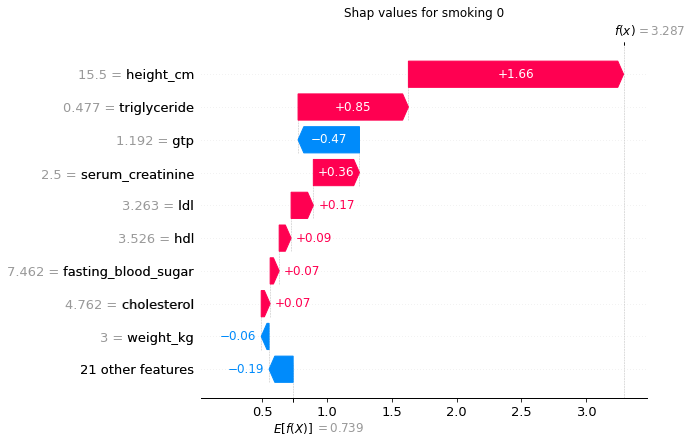

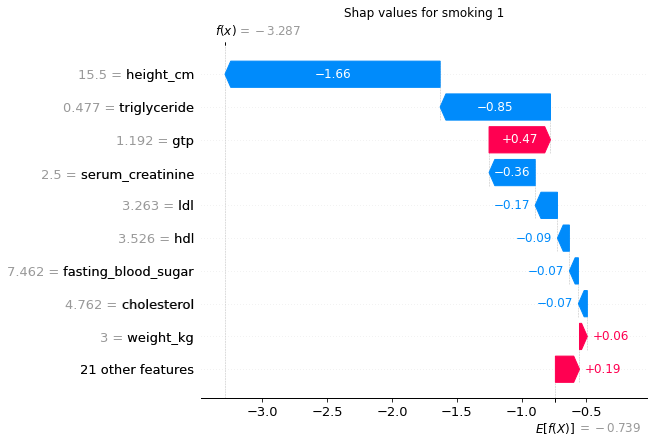

In [24]:
datapoint_id = 1485
idx = train_results[train_results.id == datapoint_id].index[0]
if target_type == 'continuous':
    shap.waterfall_plot(shap_explainer_values_train[idx])
else:
    for i, tclass in enumerate(target_classes):
        shap.waterfall_plot(shap_explainer_values_train[idx][:,i], show=False)
        plt.title(f'Shap values for {target} {tclass}')
        plt.show()

#### Test Set

In [25]:
if target_type == 'continuous':
    test_results = mlp.append_predictions(model=model, 
                                          df=X_test, 
                                          target_values=y_test,
                                          target_name=target,
                                          target_type=target_type, 
                                          df_preprocessed=X_test_preprocessed)
else:
    test_results = mlp.append_predictions(model=model, 
                                          df=X_test, 
                                          target_values=y_test,
                                          target_name=target,
                                          target_type=target_type, 
                                          df_preprocessed=X_test_preprocessed, 
                                          label_encoder=le)

test_results

id  waist_cm  eyesight_left  eyesight_right  hemoglobin  \
0       71066  5.750000           1.25            0.75        6.15   
1      103256  7.500000           3.00            3.00        7.60   
2       13685  7.416667           3.00            3.00        6.85   
3       86972  8.166667           2.25            2.25        7.45   
4       85137  7.000000           1.25            1.50        8.20   
...       ...       ...            ...             ...         ...   
31847  115346  5.441667           3.00            2.50        7.20   
31848   73703  6.583333           1.50            1.50        6.95   
31849   29579  8.333333           3.00            3.00        6.60   
31850   26069  7.025000           3.75            3.00        8.00   
31851  151518  7.416667           3.00            3.00        7.90   

       serum_creatinine       age  height_cm  weight_kg  systolic  ...  \
0                   3.5  3.000000       16.0   3.333333    6.4375  ...   
1                   5.0  2.000000       17.5   5.333333    7.9375  ...   
2                   4.0  2.666667       17.5   4.666667    7.5000  ...   
3                   5.0  3.333333       16.5   5.666667    7.6875  ...   
4                   4.0  2.666667       16.0   4.000000    7.9375  ...   
...                 ...       ...        ...        ...       ...  ...   
31847               4.5  3.000000       16.0   3.333333    5.6250  ...   
31848               4.5  4.333333       15.0   3.666667    7.3750  ...   
31849               4.5  3.333333       16.5   5.333333    8.3750  ...   
31850               5.5  2.000000       16.5   4.333333    7.6250  ...   
31851               6.0  2.666667       17.0   5.333333    8.1250  ...   

       urine_protein_3  urine_protein_4  urine_protein_5  urine_protein_6  \
0                  0.0              0.0              0.0              0.0   
1                  0.0              0.0              0.0              0.0   
2                  0.0              0.0              0.0              0.0   
3                  0.0              0.0              0.0              0.0   
4                  0.0              0.0              0.0              0.0   
...                ...              ...              ...              ...   
31847              0.0              0.0              0.0              0.0   
31848              0.0              0.0              0.0              0.0   
31849              0.0              0.0              0.0              0.0   
31850              0.0              0.0              0.0              0.0   
31851              0.0              0.0              0.0              0.0   

       dental_caries_1  dental_caries_2  pred_prob_0  pred_prob_1  \
0                  1.0              0.0     0.958898     0.041102   
1                  1.0              0.0     0.505768     0.494232   
2                  1.0              0.0     0.532439     0.467561   
3                  1.0              0.0     0.371450     0.628550   
4                  1.0              0.0     0.182057     0.817943   
...                ...              ...          ...          ...   
31847              1.0              0.0     0.914690     0.085310   
31848              1.0              0.0     0.988901     0.011099   
31849              1.0              0.0     0.958977     0.041023   
31850              1.0              0.0     0.622501     0.377499   
31851              1.0              0.0     0.454286     0.545714   

       smoking_prediction  smoking  
0                       0        0  
1                       0        0  
2                       0        1  
3                       1        1  
4                       1        1  
...                   ...      ...  
31847                   0        0  
31848                   0        0  
31849                   0        0  
31850                   0        1  
31851                   1        1  

[31852 rows x 35 columns]

##### Overall Observations vs. Predictions plot

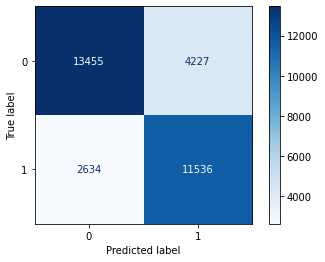

In [26]:
if target_type != 'continuous':
    target_classes = list(le.classes_)
    mlp.confusion_matrix_plot(y_true=test_results[target],
                              y_pred=test_results[target + '_prediction'],
                              labels=target_classes)

0.12778632816550417
0.10349077384442985


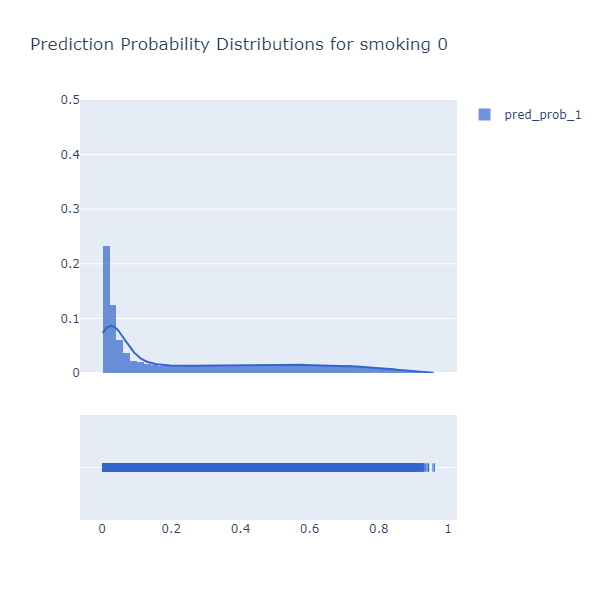

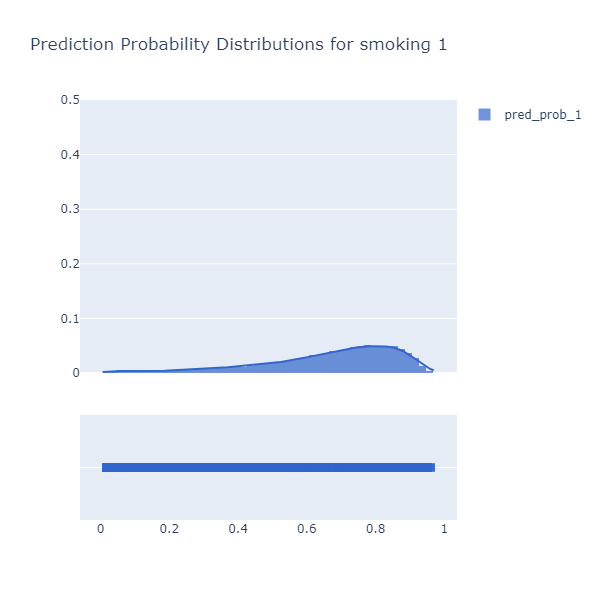

In [27]:
from sklearn.metrics import r2_score
print(r2_score(test_results[target], test_results[f"{target}_prediction"]))
print(mean_squared_log_error(test_results[target], test_results[f"{target}_prediction"].round(0)))

if target_type == 'continuous':
    hover_col = 'id'
    fig = px.scatter(test_results, 
                     x=target, 
                     y=f"{target}_prediction", 
                     hover_data=[hover_col],
                     width=600,
                     height=600)
    fig.show()
else:
    mlp.prediction_probability_distribution_plot(preds_df=test_results, 
                                                 target_classes=target_classes, 
                                                 target_colname=target,
                                                 renderer='png'
                                                 )


##### Single prediction waterfall plot

In [44]:
shap_explainer_values_test = explainer(X_test_preprocessed, y_test)

In [ ]:
datapoint_id = 1089726986
idx = test_results[test_results.entity_id == datapoint_id].index[0]
if target_type != 'multiclass':
    shap.waterfall_plot(shap_explainer_values_test[idx])
else:
    for i, tclass in enumerate(target_classes):
        shap.waterfall_plot(shap_explainer_values_test[idx][:,i], show=False)
        plt.title(f'Shap values for {target} {tclass}')
        plt.show()

### Conclusion

In [ ]:
submission_df = test_df.copy()
submission_df['Rings'] = model.predict(test_df)
submission_df = submission_df[['Rings']]
submission_df['Rings'] = submission_df['Rings']
submission_df.to_csv(f'{dataset_folder}/submission_v4.csv')
submission_df

Rings
id               
90615    9.770615
90616    9.734645
90617   10.246735
90618   10.380514
90619    7.571181
...           ...
151021   6.366440
151022   8.976341
151023  12.857599
151024  13.334564
151025   8.760720

[60411 rows x 1 columns]